In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fsps
%matplotlib inline

alldata = np.genfromtxt('ps5.data', usecols = range(15))
np.shape(alldata)
gdata = np.empty([463, 10])
gdata[:,0] = alldata[:,1]*3600+alldata[:,2]*60+alldata[:,3]
gdata[:,1] = (np.abs(alldata[:,4])*3600+alldata[:,5]*60+alldata[:,6])*np.sign(alldata[:,4])
gdata[:,2:] = alldata[:,7:]
gdata

array([[  2.25000000e+01,   1.42184000e+05,   8.20000000e+00, ...,
          9.99900000e+01,   9.99900000e+01,   9.99900000e+01],
       [  1.18100000e+02,  -5.56590000e+04,   9.20000000e-01, ...,
          5.00000000e-02,   1.23500000e+01,   3.00000000e-02],
       [  3.31800000e+02,  -1.01153000e+05,   1.04000000e+01, ...,
          5.00000000e-02,   1.58200000e+01,   4.00000000e-02],
       ..., 
       [  5.00735000e+04,   1.52750000e+04,   2.59000000e+00, ...,
          1.20000000e-01,   1.85400000e+01,   1.10000000e-01],
       [  5.84279000e+04,   1.95736000e+05,   1.93000000e+00, ...,
          9.99900000e+01,   1.91100000e+01,   6.00000000e-02],
       [  8.55340000e+04,   1.39384000e+05,   2.54000000e+00, ...,
          6.00000000e-02,   1.70000000e+01,   4.00000000e-02]])

In [3]:
metallicity = 6.27 - .11*(gdata[:,3]-5*(np.log10(gdata[:,2]*1e5)))

fuv_sfr = []
fuv_err = []
M_B = []
masses = []
for i in range(len(gdata[:,-4])):
    if (gdata[i,-4] == 99.99) | (gdata[i,-3] == 99.99) :
        pass
    else:
        absmag = np.log10(gdata[i,-4])-5*(np.log10(gdata[i,2]*1e6)-1) # absolute magnitude
        F_nuv = 10**(-.4*(absmag+48.6))
        L_nuv = 4*np.pi*(10*3.08e18)**2* F_nuv
        powL_nuv = L_nuv*(3e18/1528.) 
        fuv_sfr1 = -np.log10(powL_nuv) + 43.35
        err = np.log10(gdata[i,-4]+gdata[i,-3])-5*(np.log10(gdata[i,2]*1e6)-1)
        F_nuverr = 10**(-.4*(err+48.6))
        L_nuverr = 4*np.pi*(10*3.08e18)**2* F_nuverr
        powL_nuverr = L_nuverr*(3e18/1528.) 
        fuv_err1 = -np.log10(powL_nuverr) + 43.35- fuv_sfr1
        fuv_sfr.append(fuv_sfr1)
        fuv_err.append(gdata[i,-3])
        M_now = gdata[i,3]-5*(np.log10(gdata[i,2]*1e6)-1)
        M_B.append(M_now)
        mass = (13.3-M_now)/2.5
        masses.append(mass)

fuv_sfr = np.asarray(fuv_sfr)
fuv_err = np.asarray(fuv_err)
M_B = np.asarray(M_B)
masses = np.asarray(masses)
print(max(M_B), min(M_B))

-6.71624645199 -20.8624147428


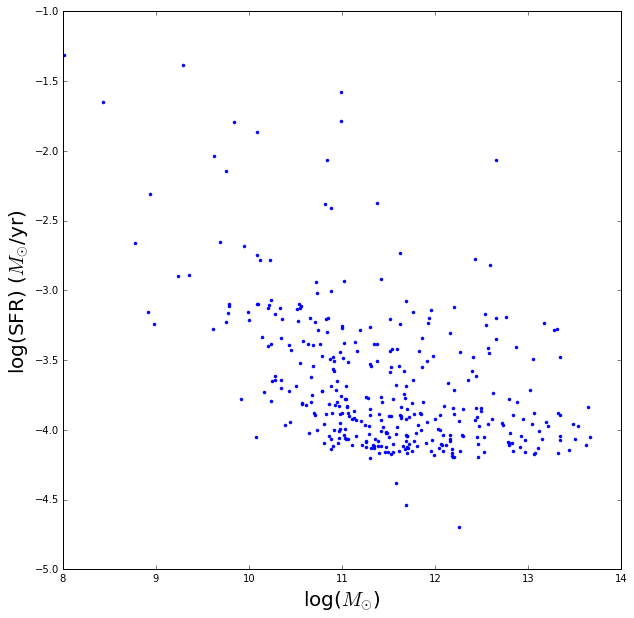

In [6]:
plt.figure(figsize=(10,10))
plt.plot(masses, fuv_sfr, '.')
plt.xlabel('log($M_{\odot}$)', fontsize = 20)
plt.ylabel('log(SFR) ($M_{\odot}$/yr)', fontsize = 20)

In [7]:
fuv_err

array([ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.06,  0.05,  0.06,
        0.06,  0.05,  0.05,  0.05,  0.05,  0.05,  0.11,  0.05,  0.05,
        0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.09,  0.09,
        0.05,  0.05,  0.05,  0.09,  0.2 ,  0.05,  0.09,  0.08,  0.13,
        0.19,  0.08,  0.05,  0.09,  0.08,  0.06,  0.11,  0.11,  0.05,
        0.05,  0.05,  0.05,  0.09,  0.06,  0.1 ,  0.08,  0.05,  0.19,
        0.06,  0.05,  0.13,  0.06,  0.06,  0.05,  0.06,  0.05,  0.05,
        0.05,  0.05,  0.05,  0.05,  0.06,  0.05,  0.05,  0.05,  0.05,
        0.18,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.1 ,  0.07,
        0.05,  0.06,  0.05,  0.07,  0.1 ,  0.07,  0.11,  0.09,  0.06,
        0.25,  0.07,  0.05,  0.05,  0.06,  0.05,  0.06,  0.05,  0.06,
        0.05,  0.05,  0.05,  0.05,  0.05,  0.06,  0.05,  0.05,  0.05,
        0.07,  0.07,  0.05,  0.37,  0.13,  0.05,  0.06,  0.15,  0.05,
        0.05,  0.88,  0.09,  0.05,  0.09,  0.05,  0.06,  0.05,  0.05,
        0.05,  0.06,

I have decided to incorporate the mass errors trigonometrically since I couldn't think of a way to include x errors in the emcee process

In [8]:
fullerr = np.sqrt(fuv_err**2+.04**2)

In [10]:
import emcee

def lnprob(theta, x, y, err):
    model = theta[0]+ x*theta[1]
    val = -.5*np.sum((y-model)**2/err**2)
    return val

ndim, nwalkers = 2, 100
pos = [1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = [masses, fuv_sfr, fullerr])
sampler.run_mcmc(pos, 10000)

(array([[-1.17014713, -0.21701546],
        [-1.16468268, -0.2175835 ],
        [-1.21946028, -0.21305048],
        [-1.20996803, -0.21357358],
        [-1.17050924, -0.21765491],
        [-1.18592636, -0.21650288],
        [-1.10856641, -0.22242107],
        [-1.2311275 , -0.21130013],
        [-1.19536358, -0.21456557],
        [-1.07875345, -0.22500946],
        [-1.15250139, -0.21831845],
        [-1.08228826, -0.22507467],
        [-1.0975575 , -0.22306226],
        [-1.14417177, -0.21968649],
        [-1.20043023, -0.21445723],
        [-1.14600454, -0.21862544],
        [-1.19389203, -0.2142299 ],
        [-1.1573476 , -0.21842426],
        [-1.08122163, -0.22462137],
        [-1.18119814, -0.2166384 ],
        [-1.15070055, -0.21869367],
        [-1.1029555 , -0.22347982],
        [-1.15602154, -0.21839534],
        [-1.18755067, -0.21584974],
        [-1.18304957, -0.2160265 ],
        [-1.18420397, -0.21621255],
        [-1.19067313, -0.2154052 ],
        [-1.21915585, -0.212

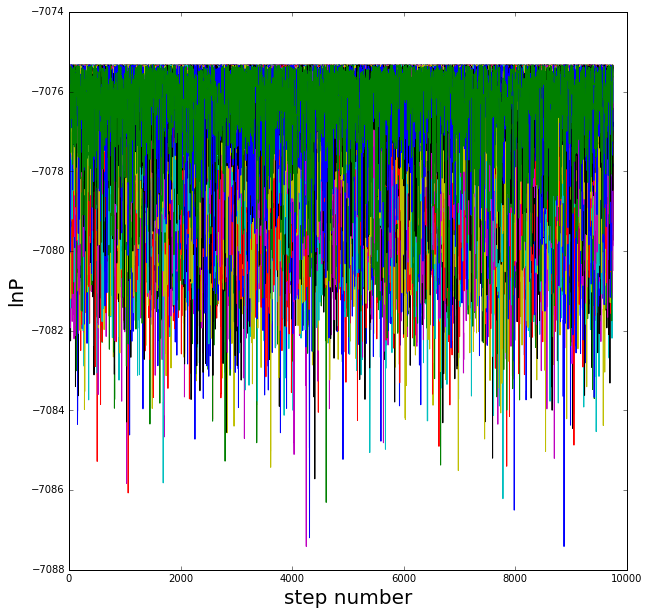

In [11]:
plt.figure(figsize = (10,10))
[plt.plot(sampler.lnprobability[i,250:]) for i in range(100)]
plt.xlabel('step number', fontsize = 20)
plt.ylabel('lnP', fontsize = 20)

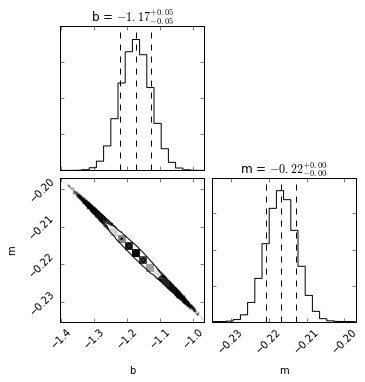

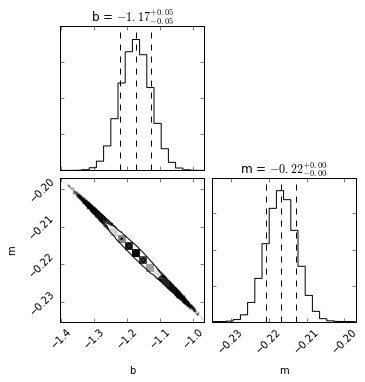

In [12]:
import corner

samples = sampler.chain[:,250:, :].reshape((-1, ndim))
corner.corner(samples, labels=['b', 'm'], fontsize = 20, show_titles = True, quantiles=[0.16, 0.5, 0.84])

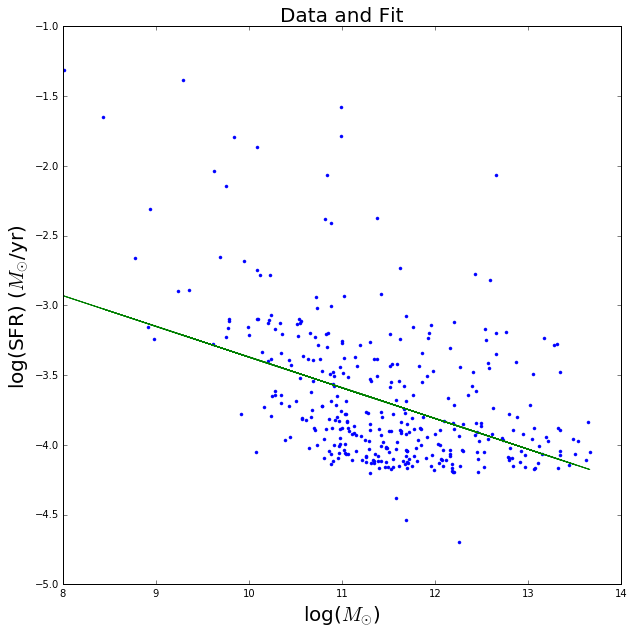

In [18]:
plt.figure(figsize=(10,10))
plt.plot(masses, fuv_sfr, '.')
plt.plot(masses, -.22*masses-1.17)
plt.title('Data and Fit', fontsize = 20)
plt.xlabel('log($M_{\odot}$)', fontsize = 20)
plt.ylabel('log(SFR) ($M_{\odot}$/yr)', fontsize = 20)

I don't know if it is because my calculation was incorrect or not, but a plain line doesn't look like a great fit to this data, even logspace. The logL seems to say the same.

In [15]:
metals = 6.27 - .11*M_B
print(max(metals), min(metals))

8.5648656217 7.00878710972


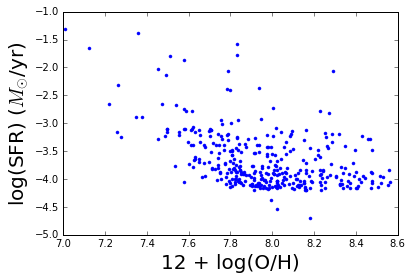

In [20]:
plt.plot(metals, fuv_sfr, '.')
plt.xlabel('12 + log(O/H)', fontsize = 20)
plt.ylabel('log(SFR) ($M_{\odot}$/yr)', fontsize = 20)

Error in M_B has to be converted into an error in metals.

In [22]:
metalerr = .1*.11
fullerr2 = np.sqrt(metalerr**2+fuv_err**2)

In [23]:
import emcee

def lnprob(theta, x, y, err):
    model = theta[0]+ x*theta[1]
    val = -.5*np.sum((y-model)**2/err**2)
    return val

ndim, nwalkers = 2, 100
pos = [1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = [metals, fuv_sfr, fullerr2])
sampler.run_mcmc(pos, 10000)

(array([[ 2.68985072, -0.79675791],
        [ 2.5981589 , -0.78522178],
        [ 2.6536473 , -0.79272729],
        [ 2.69816305, -0.79739203],
        [ 2.68953986, -0.79674005],
        [ 2.53148615, -0.77711388],
        [ 2.49355479, -0.77231796],
        [ 2.45579995, -0.76782439],
        [ 2.58616168, -0.78352458],
        [ 2.58289567, -0.78362579],
        [ 2.69894425, -0.7981916 ],
        [ 2.61633175, -0.78748092],
        [ 2.59756036, -0.78550986],
        [ 2.37325406, -0.75842969],
        [ 2.49680992, -0.77303473],
        [ 2.51696441, -0.77587972],
        [ 2.53772017, -0.77798949],
        [ 2.54106421, -0.7785104 ],
        [ 2.58635538, -0.78409272],
        [ 2.56955044, -0.78138399],
        [ 2.62271519, -0.78899126],
        [ 2.67479424, -0.79521132],
        [ 2.51278928, -0.77531449],
        [ 2.43239057, -0.76538589],
        [ 2.59236216, -0.78496936],
        [ 2.58754417, -0.78389941],
        [ 2.51990846, -0.77500261],
        [ 2.53116954, -0.777

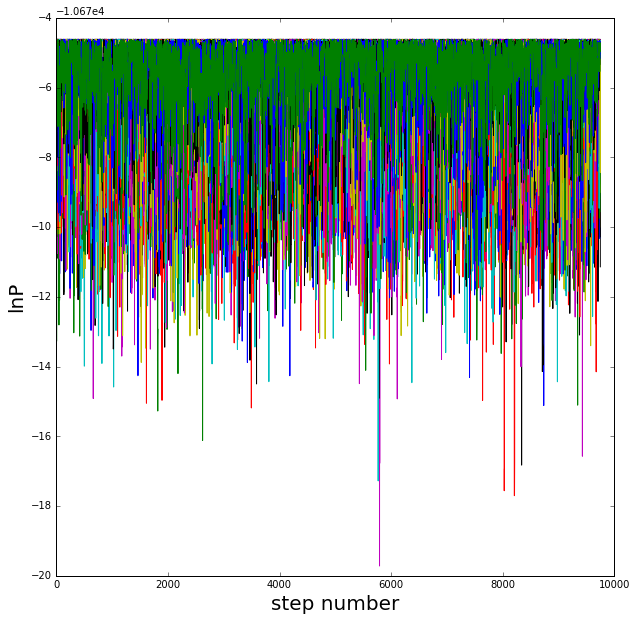

In [24]:
plt.figure(figsize = (10,10))
[plt.plot(sampler.lnprobability[i,250:]) for i in range(100)]
plt.xlabel('step number', fontsize = 20)
plt.ylabel('lnP', fontsize = 20)

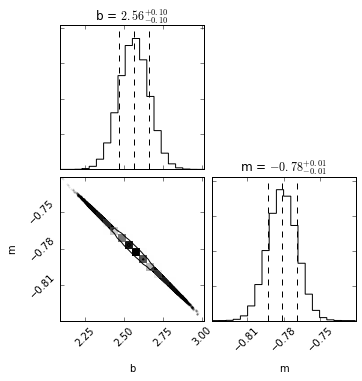

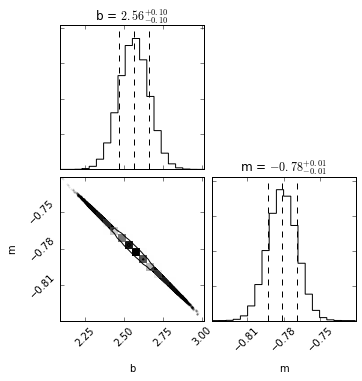

In [25]:
import corner

samples = sampler.chain[:,250:, :].reshape((-1, ndim))
corner.corner(samples, labels=['b', 'm'], fontsize = 20, show_titles = True, quantiles=[0.16, 0.5, 0.84])

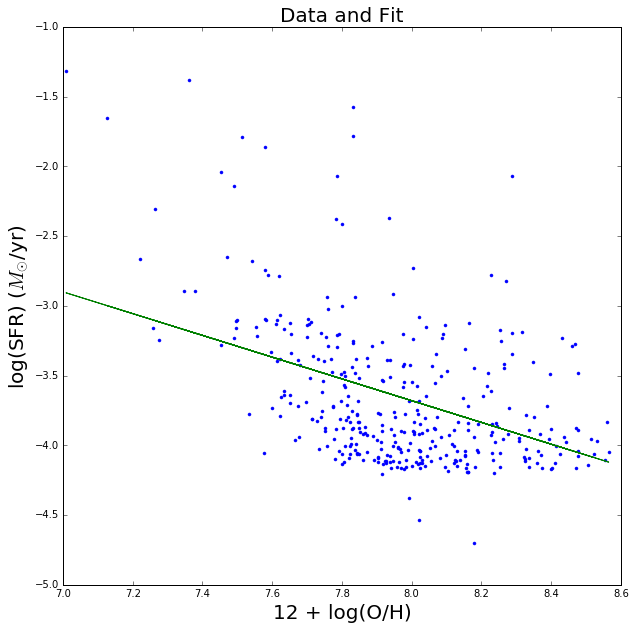

In [26]:
plt.figure(figsize=(10,10))
plt.plot(metals, fuv_sfr, '.')
plt.plot(metals, -.78*metals+2.56)
plt.title('Data and Fit', fontsize = 20)
plt.xlabel('12 + log(O/H)', fontsize = 20)
plt.ylabel('log(SFR) ($M_{\odot}$/yr)', fontsize = 20)

Still a line doesn't look like a good fit!

Assuming that these relations (magnitude-mass, magnitude-metallicity, mass-metallicity) are entirely linear will just lead to the cloudy, nonlinear relation seen in the SFR-mass and SFR-metallicity plots. Additionally, I don't think I took the mass/metallicity errors in the most mathematically rigorous way. If we were able to take into the account the intrinsic scatter in the initial linear relationships or instead find a second-order relationship that complicates the linear relationship, we might find less scatter in these derived parameters and a better fit overall to some single relation, even if it isn't linear.